In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal

In [2]:
data = pd.read_csv('c172_file_1.csv')
data

,AltAGL,AltB,AltGPS,AltMSL,BaroA,E1_CHT1,E1_CHT2,E1_CHT3,E1_CHT4,E1_EGT1,...,LatAc,NormAc,OAT,Pitch,Roll,TAS,VSpd,VSpdG,WndDr,WndSpd
0,0.0,855.8,745.7,833.6,30.05,231.88,224.27,243.57,245.74,1047.12,...,0.01,0.01,27.2,1.25,-0.21,0.0,-14.35,-3.9,0.0,0.0
1,0.0,856.8,746.2,834.0,30.05,232.23,224.58,243.87,246.04,1046.06,...,0.01,-0.00,27.2,1.23,-0.15,0.0,0.74,-3.9,0.0,0.0
2,0.0,855.8,746.4,834.2,30.05,232.59,224.84,244.12,246.34,1046.17,...,0.00,-0.01,27.2,1.21,-0.14,0.0,5.96,-3.9,0.0,0.0
3,0.0,856.8,745.2,833.1,30.05,232.96,225.10,244.46,246.59,1046.32,...,-0.00,-0.01,27.2,1.22,-0.14,0.0,9.95,-3.9,0.0,0.0
4,0.0,856.8,745.2,833.0,30.05,233.30,225.36,244.75,246.86,1043.91,...,0.01,-0.01,27.2,1.22,-0.10,0.0,13.36,-3.9,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5055,0.0,844.2,751.5,839.3,30.02,282.56,270.85,296.29,288.37,1041.83,...,0.00,0.04,26.0,1.45,0.00,0.0,15.17,-3.9,0.0,0.0
5056,0.0,844.2,751.6,839.4,30.02,282.49,270.90,296.36,288.45,1036.33,...,0.00,-0.02,26.0,1.29,0.03,0.0,15.98,0.0,0.0,0.0
5057,0.0,844.2,751.7,839.5,30.02,282.43,270.93,296.42,288.52,1030.14,...,0.00,0.01,26.0,1.76,0.02,0.0,17.44,0.0,0.0,0.0
5058,1.0,845.2,752.4,840.2,30.02,282.55,271.14,296.58,288.66,1024.47,...,-0.00,-0.01,26.0,1.80,0.01,0.0,25.02,0.0,0.0,0.0


In [3]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = x[start:(start+batch_size)]
    #print(batch.shape)
    return batch

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def loss_fn(recon_x, x, mu, logvar):
        BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
        return BCE + KLD

In [4]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2) #is it saying its getting a mu and a var for each z dim out?
            
            #how can I represent the encoder as a distribution acting as the prior?
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )
    
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        #print(mu.shape)
        #print(logvar.shape)
        z = self.reparameterize(mu, logvar)
        #print(z.shape)
        #z = z.float()
        z = model(z)
        #print(z)
        tensorZ = z[0]#torch.tensor(z[0])
        #print(tensorZ.shape)
        #print(z[0])
        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 

        if flip:
            x2, x1 = x1, x2
        
        # forward
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2
        
        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [19]:
step_size = 5
batch = 512
index_step_length = 31
epochs = 1000

d = 2
k = 1

base_mu, base_cov = torch.zeros(2), torch.eye(2)
base_mu = base_mu.double()
base_cov = base_cov.double()
#base_mu = Variable(base_mu.cuda())
#base_cov = Variable(base_cov.cuda())
base_mu = Variable(base_mu)
base_cov = Variable(base_cov)
base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(data, step_size)
#XX.cuda()
demo = VAE(index_step_length,h_dim=18,z_dim=2)
model = stacked_NVP(d, k, hidden=512,n=1)
#demo.cuda()
#model.cuda()
demo.double()
model.double()
#next set of tests should be with n=3, last set was with n=1
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.RMSprop(demo.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/1000] Loss: 0.197
Epoch[1/1000] Loss: 0.215
Epoch[1/1000] Loss: 0.193
Epoch[1/1000] Loss: 0.192
Epoch[1/1000] Loss: 0.216
Epoch[2/1000] Loss: 0.190
Epoch[2/1000] Loss: 0.195
Epoch[2/1000] Loss: 0.190
Epoch[2/1000] Loss: 0.198
Epoch[2/1000] Loss: 0.201
Epoch[3/1000] Loss: 0.204
Epoch[3/1000] Loss: 0.201
Epoch[3/1000] Loss: 0.187
Epoch[3/1000] Loss: 0.203
Epoch[3/1000] Loss: 0.177
Epoch[4/1000] Loss: 0.202
Epoch[4/1000] Loss: 0.148
Epoch[4/1000] Loss: 0.166
Epoch[4/1000] Loss: 0.230
Epoch[4/1000] Loss: 0.195
Epoch[5/1000] Loss: 0.192
Epoch[5/1000] Loss: 0.157
Epoch[5/1000] Loss: 0.205
Epoch[5/1000] Loss: 0.169
Epoch[5/1000] Loss: 0.203
Epoch[6/1000] Loss: 0.171
Epoch[6/1000] Loss: 0.160
Epoch[6/1000] Loss: 0.179
Epoch[6/1000] Loss: 0.168
Epoch[6/1000] Loss: 0.171
Epoch[7/1000] Loss: 0.187
Epoch[7/1000] Loss: 0.152
Epoch[7/1000] Loss: 0.192
Epoch[7/1000] Loss: 0.167
Epoch[7/1000] Loss: 0.162
Epoch[8/1000] Loss: 0.168
Epoch[8/1000] Loss: 0.193
Epoch[8/1000] Loss: 0.167
Epoch[8/1000

Epoch[61/1000] Loss: 0.201
Epoch[61/1000] Loss: 0.179
Epoch[61/1000] Loss: 0.188
Epoch[61/1000] Loss: 0.178
Epoch[61/1000] Loss: 0.190
Epoch[62/1000] Loss: 0.186
Epoch[62/1000] Loss: 0.206
Epoch[62/1000] Loss: 0.170
Epoch[62/1000] Loss: 0.194
Epoch[62/1000] Loss: 0.199
Epoch[63/1000] Loss: 0.205
Epoch[63/1000] Loss: 0.163
Epoch[63/1000] Loss: 0.191
Epoch[63/1000] Loss: 0.205
Epoch[63/1000] Loss: 0.194
Epoch[64/1000] Loss: 0.163
Epoch[64/1000] Loss: 0.189
Epoch[64/1000] Loss: 0.200
Epoch[64/1000] Loss: 0.198
Epoch[64/1000] Loss: 0.198
Epoch[65/1000] Loss: 0.165
Epoch[65/1000] Loss: 0.152
Epoch[65/1000] Loss: 0.198
Epoch[65/1000] Loss: 0.145
Epoch[65/1000] Loss: 0.173
Epoch[66/1000] Loss: 0.169
Epoch[66/1000] Loss: 0.193
Epoch[66/1000] Loss: 0.163
Epoch[66/1000] Loss: 0.194
Epoch[66/1000] Loss: 0.190
Epoch[67/1000] Loss: 0.145
Epoch[67/1000] Loss: 0.236
Epoch[67/1000] Loss: 0.176
Epoch[67/1000] Loss: 0.175
Epoch[67/1000] Loss: 0.195
Epoch[67/1000] Loss: 0.182
Epoch[68/1000] Loss: 0.176
E

Epoch[119/1000] Loss: 0.165
Epoch[119/1000] Loss: 0.203
Epoch[120/1000] Loss: 0.232
Epoch[120/1000] Loss: 0.190
Epoch[120/1000] Loss: 0.160
Epoch[120/1000] Loss: 0.198
Epoch[120/1000] Loss: 0.195
Epoch[121/1000] Loss: 0.226
Epoch[121/1000] Loss: 0.176
Epoch[121/1000] Loss: 0.172
Epoch[121/1000] Loss: 0.192
Epoch[121/1000] Loss: 0.183
Epoch[122/1000] Loss: 0.195
Epoch[122/1000] Loss: 0.148
Epoch[122/1000] Loss: 0.206
Epoch[122/1000] Loss: 0.160
Epoch[122/1000] Loss: 0.192
Epoch[123/1000] Loss: 0.170
Epoch[123/1000] Loss: 0.192
Epoch[123/1000] Loss: 0.198
Epoch[123/1000] Loss: 0.145
Epoch[123/1000] Loss: 0.168
Epoch[124/1000] Loss: 0.198
Epoch[124/1000] Loss: 0.179
Epoch[124/1000] Loss: 0.195
Epoch[124/1000] Loss: 0.187
Epoch[124/1000] Loss: 0.202
Epoch[125/1000] Loss: 0.145
Epoch[125/1000] Loss: 0.166
Epoch[125/1000] Loss: 0.145
Epoch[125/1000] Loss: 0.194
Epoch[125/1000] Loss: 0.151
Epoch[125/1000] Loss: 0.171
Epoch[126/1000] Loss: 0.204
Epoch[126/1000] Loss: 0.174
Epoch[126/1000] Loss

Epoch[177/1000] Loss: 0.174
Epoch[177/1000] Loss: 0.199
Epoch[177/1000] Loss: 0.190
Epoch[177/1000] Loss: 0.151
Epoch[177/1000] Loss: 0.147
Epoch[178/1000] Loss: 0.167
Epoch[178/1000] Loss: 0.160
Epoch[178/1000] Loss: 0.170
Epoch[178/1000] Loss: 0.192
Epoch[178/1000] Loss: 0.199
Epoch[179/1000] Loss: 0.152
Epoch[179/1000] Loss: 0.169
Epoch[179/1000] Loss: 0.196
Epoch[179/1000] Loss: 0.211
Epoch[179/1000] Loss: 0.189
Epoch[180/1000] Loss: 0.179
Epoch[180/1000] Loss: 0.197
Epoch[180/1000] Loss: 0.188
Epoch[180/1000] Loss: 0.151
Epoch[180/1000] Loss: 0.146
Epoch[181/1000] Loss: 0.142
Epoch[181/1000] Loss: 0.170
Epoch[181/1000] Loss: 0.145
Epoch[181/1000] Loss: 0.197
Epoch[181/1000] Loss: 0.148
Epoch[182/1000] Loss: 0.235
Epoch[182/1000] Loss: 0.168
Epoch[182/1000] Loss: 0.149
Epoch[182/1000] Loss: 0.166
Epoch[182/1000] Loss: 0.218
Epoch[183/1000] Loss: 0.173
Epoch[183/1000] Loss: 0.166
Epoch[183/1000] Loss: 0.184
Epoch[183/1000] Loss: 0.198
Epoch[183/1000] Loss: 0.200
Epoch[184/1000] Loss

Epoch[234/1000] Loss: 0.206
Epoch[234/1000] Loss: 0.196
Epoch[234/1000] Loss: 0.196
Epoch[235/1000] Loss: 0.160
Epoch[235/1000] Loss: 0.193
Epoch[235/1000] Loss: 0.190
Epoch[235/1000] Loss: 0.233
Epoch[235/1000] Loss: 0.200
Epoch[236/1000] Loss: 0.200
Epoch[236/1000] Loss: 0.202
Epoch[236/1000] Loss: 0.198
Epoch[236/1000] Loss: 0.172
Epoch[236/1000] Loss: 0.175
Epoch[237/1000] Loss: 0.164
Epoch[237/1000] Loss: 0.196
Epoch[237/1000] Loss: 0.196
Epoch[237/1000] Loss: 0.171
Epoch[237/1000] Loss: 0.193
Epoch[238/1000] Loss: 0.198
Epoch[238/1000] Loss: 0.167
Epoch[238/1000] Loss: 0.143
Epoch[238/1000] Loss: 0.196
Epoch[238/1000] Loss: 0.186
Epoch[239/1000] Loss: 0.185
Epoch[239/1000] Loss: 0.220
Epoch[239/1000] Loss: 0.197
Epoch[239/1000] Loss: 0.144
Epoch[239/1000] Loss: 0.209
Epoch[240/1000] Loss: 0.166
Epoch[240/1000] Loss: 0.246
Epoch[240/1000] Loss: 0.198
Epoch[240/1000] Loss: 0.194
Epoch[240/1000] Loss: 0.172
Epoch[241/1000] Loss: 0.145
Epoch[241/1000] Loss: 0.200
Epoch[241/1000] Loss

Epoch[292/1000] Loss: 0.148
Epoch[292/1000] Loss: 0.175
Epoch[292/1000] Loss: 0.206
Epoch[292/1000] Loss: 0.225
Epoch[292/1000] Loss: 0.163
Epoch[292/1000] Loss: 0.173
Epoch[293/1000] Loss: 0.198
Epoch[293/1000] Loss: 0.201
Epoch[293/1000] Loss: 0.196
Epoch[293/1000] Loss: 0.241
Epoch[293/1000] Loss: 0.199
Epoch[294/1000] Loss: 0.152
Epoch[294/1000] Loss: 0.162
Epoch[294/1000] Loss: 0.185
Epoch[294/1000] Loss: 0.158
Epoch[294/1000] Loss: 0.199
Epoch[295/1000] Loss: 0.186
Epoch[295/1000] Loss: 0.197
Epoch[295/1000] Loss: 0.178
Epoch[295/1000] Loss: 0.183
Epoch[295/1000] Loss: 0.200
Epoch[296/1000] Loss: 0.188
Epoch[296/1000] Loss: 0.153
Epoch[296/1000] Loss: 0.203
Epoch[296/1000] Loss: 0.161
Epoch[296/1000] Loss: 0.208
Epoch[297/1000] Loss: 0.191
Epoch[297/1000] Loss: 0.238
Epoch[297/1000] Loss: 0.150
Epoch[297/1000] Loss: 0.195
Epoch[297/1000] Loss: 0.162
Epoch[298/1000] Loss: 0.184
Epoch[298/1000] Loss: 0.162
Epoch[298/1000] Loss: 0.198
Epoch[298/1000] Loss: 0.203
Epoch[298/1000] Loss

Epoch[349/1000] Loss: 0.203
Epoch[349/1000] Loss: 0.150
Epoch[349/1000] Loss: 0.203
Epoch[349/1000] Loss: 0.161
Epoch[350/1000] Loss: 0.169
Epoch[350/1000] Loss: 0.199
Epoch[350/1000] Loss: 0.189
Epoch[350/1000] Loss: 0.152
Epoch[350/1000] Loss: 0.146
Epoch[350/1000] Loss: 0.196
Epoch[351/1000] Loss: 0.175
Epoch[351/1000] Loss: 0.170
Epoch[351/1000] Loss: 0.196
Epoch[351/1000] Loss: 0.204
Epoch[351/1000] Loss: 0.201
Epoch[352/1000] Loss: 0.207
Epoch[352/1000] Loss: 0.195
Epoch[352/1000] Loss: 0.189
Epoch[352/1000] Loss: 0.162
Epoch[352/1000] Loss: 0.172
Epoch[353/1000] Loss: 0.169
Epoch[353/1000] Loss: 0.198
Epoch[353/1000] Loss: 0.188
Epoch[353/1000] Loss: 0.195
Epoch[353/1000] Loss: 0.147
Epoch[354/1000] Loss: 0.162
Epoch[354/1000] Loss: 0.171
Epoch[354/1000] Loss: 0.170
Epoch[354/1000] Loss: 0.180
Epoch[354/1000] Loss: 0.219
Epoch[355/1000] Loss: 0.149
Epoch[355/1000] Loss: 0.187
Epoch[355/1000] Loss: 0.196
Epoch[355/1000] Loss: 0.147
Epoch[355/1000] Loss: 0.200
Epoch[356/1000] Loss

Epoch[406/1000] Loss: 0.153
Epoch[406/1000] Loss: 0.159
Epoch[406/1000] Loss: 0.189
Epoch[407/1000] Loss: 0.165
Epoch[407/1000] Loss: 0.183
Epoch[407/1000] Loss: 0.205
Epoch[407/1000] Loss: 0.185
Epoch[407/1000] Loss: 0.159
Epoch[408/1000] Loss: 0.230
Epoch[408/1000] Loss: 0.195
Epoch[408/1000] Loss: 0.167
Epoch[408/1000] Loss: 0.195
Epoch[408/1000] Loss: 0.145
Epoch[409/1000] Loss: 0.194
Epoch[409/1000] Loss: 0.143
Epoch[409/1000] Loss: 0.154
Epoch[409/1000] Loss: 0.228
Epoch[409/1000] Loss: 0.196
Epoch[409/1000] Loss: 0.157
Epoch[410/1000] Loss: 0.201
Epoch[410/1000] Loss: 0.163
Epoch[410/1000] Loss: 0.177
Epoch[410/1000] Loss: 0.150
Epoch[410/1000] Loss: 0.239
Epoch[411/1000] Loss: 0.202
Epoch[411/1000] Loss: 0.192
Epoch[411/1000] Loss: 0.200
Epoch[411/1000] Loss: 0.226
Epoch[411/1000] Loss: 0.189
Epoch[412/1000] Loss: 0.199
Epoch[412/1000] Loss: 0.201
Epoch[412/1000] Loss: 0.148
Epoch[412/1000] Loss: 0.162
Epoch[412/1000] Loss: 0.168
Epoch[413/1000] Loss: 0.200
Epoch[413/1000] Loss

Epoch[463/1000] Loss: 0.163
Epoch[463/1000] Loss: 0.199
Epoch[464/1000] Loss: 0.196
Epoch[464/1000] Loss: 0.190
Epoch[464/1000] Loss: 0.165
Epoch[464/1000] Loss: 0.161
Epoch[464/1000] Loss: 0.183
Epoch[465/1000] Loss: 0.185
Epoch[465/1000] Loss: 0.201
Epoch[465/1000] Loss: 0.198
Epoch[465/1000] Loss: 0.194
Epoch[465/1000] Loss: 0.193
Epoch[466/1000] Loss: 0.189
Epoch[466/1000] Loss: 0.163
Epoch[466/1000] Loss: 0.199
Epoch[466/1000] Loss: 0.171
Epoch[466/1000] Loss: 0.222
Epoch[467/1000] Loss: 0.201
Epoch[467/1000] Loss: 0.167
Epoch[467/1000] Loss: 0.190
Epoch[467/1000] Loss: 0.155
Epoch[467/1000] Loss: 0.195
Epoch[467/1000] Loss: 0.146
Epoch[468/1000] Loss: 0.168
Epoch[468/1000] Loss: 0.176
Epoch[468/1000] Loss: 0.199
Epoch[468/1000] Loss: 0.175
Epoch[468/1000] Loss: 0.201
Epoch[469/1000] Loss: 0.167
Epoch[469/1000] Loss: 0.209
Epoch[469/1000] Loss: 0.184
Epoch[469/1000] Loss: 0.167
Epoch[469/1000] Loss: 0.177
Epoch[470/1000] Loss: 0.197
Epoch[470/1000] Loss: 0.164
Epoch[470/1000] Loss

Epoch[520/1000] Loss: 0.233
Epoch[521/1000] Loss: 0.195
Epoch[521/1000] Loss: 0.205
Epoch[521/1000] Loss: 0.237
Epoch[521/1000] Loss: 0.185
Epoch[521/1000] Loss: 0.200
Epoch[522/1000] Loss: 0.145
Epoch[522/1000] Loss: 0.200
Epoch[522/1000] Loss: 0.144
Epoch[522/1000] Loss: 0.197
Epoch[522/1000] Loss: 0.200
Epoch[523/1000] Loss: 0.198
Epoch[523/1000] Loss: 0.159
Epoch[523/1000] Loss: 0.178
Epoch[523/1000] Loss: 0.207
Epoch[523/1000] Loss: 0.199
Epoch[524/1000] Loss: 0.233
Epoch[524/1000] Loss: 0.199
Epoch[524/1000] Loss: 0.163
Epoch[524/1000] Loss: 0.163
Epoch[524/1000] Loss: 0.198
Epoch[525/1000] Loss: 0.204
Epoch[525/1000] Loss: 0.179
Epoch[525/1000] Loss: 0.204
Epoch[525/1000] Loss: 0.194
Epoch[525/1000] Loss: 0.145
Epoch[525/1000] Loss: 0.188
Epoch[526/1000] Loss: 0.176
Epoch[526/1000] Loss: 0.153
Epoch[526/1000] Loss: 0.160
Epoch[526/1000] Loss: 0.159
Epoch[526/1000] Loss: 0.168
Epoch[527/1000] Loss: 0.146
Epoch[527/1000] Loss: 0.200
Epoch[527/1000] Loss: 0.186
Epoch[527/1000] Loss

Epoch[578/1000] Loss: 0.165
Epoch[578/1000] Loss: 0.198
Epoch[578/1000] Loss: 0.197
Epoch[578/1000] Loss: 0.186
Epoch[579/1000] Loss: 0.187
Epoch[579/1000] Loss: 0.190
Epoch[579/1000] Loss: 0.162
Epoch[579/1000] Loss: 0.170
Epoch[579/1000] Loss: 0.169
Epoch[580/1000] Loss: 0.173
Epoch[580/1000] Loss: 0.206
Epoch[580/1000] Loss: 0.171
Epoch[580/1000] Loss: 0.166
Epoch[580/1000] Loss: 0.199
Epoch[581/1000] Loss: 0.196
Epoch[581/1000] Loss: 0.185
Epoch[581/1000] Loss: 0.172
Epoch[581/1000] Loss: 0.163
Epoch[581/1000] Loss: 0.165
Epoch[582/1000] Loss: 0.159
Epoch[582/1000] Loss: 0.195
Epoch[582/1000] Loss: 0.146
Epoch[582/1000] Loss: 0.158
Epoch[582/1000] Loss: 0.166
Epoch[583/1000] Loss: 0.149
Epoch[583/1000] Loss: 0.192
Epoch[583/1000] Loss: 0.160
Epoch[583/1000] Loss: 0.176
Epoch[583/1000] Loss: 0.208
Epoch[584/1000] Loss: 0.167
Epoch[584/1000] Loss: 0.194
Epoch[584/1000] Loss: 0.203
Epoch[584/1000] Loss: 0.194
Epoch[584/1000] Loss: 0.250
Epoch[584/1000] Loss: 0.220
Epoch[585/1000] Loss

Epoch[635/1000] Loss: 0.193
Epoch[635/1000] Loss: 0.145
Epoch[635/1000] Loss: 0.199
Epoch[636/1000] Loss: 0.198
Epoch[636/1000] Loss: 0.189
Epoch[636/1000] Loss: 0.200
Epoch[636/1000] Loss: 0.165
Epoch[636/1000] Loss: 0.187
Epoch[637/1000] Loss: 0.198
Epoch[637/1000] Loss: 0.160
Epoch[637/1000] Loss: 0.225
Epoch[637/1000] Loss: 0.185
Epoch[637/1000] Loss: 0.201
Epoch[638/1000] Loss: 0.168
Epoch[638/1000] Loss: 0.176
Epoch[638/1000] Loss: 0.201
Epoch[638/1000] Loss: 0.175
Epoch[638/1000] Loss: 0.234
Epoch[639/1000] Loss: 0.219
Epoch[639/1000] Loss: 0.203
Epoch[639/1000] Loss: 0.157
Epoch[639/1000] Loss: 0.198
Epoch[639/1000] Loss: 0.184
Epoch[640/1000] Loss: 0.185
Epoch[640/1000] Loss: 0.197
Epoch[640/1000] Loss: 0.195
Epoch[640/1000] Loss: 0.197
Epoch[640/1000] Loss: 0.201
Epoch[641/1000] Loss: 0.182
Epoch[641/1000] Loss: 0.169
Epoch[641/1000] Loss: 0.194
Epoch[641/1000] Loss: 0.163
Epoch[641/1000] Loss: 0.188
Epoch[642/1000] Loss: 0.222
Epoch[642/1000] Loss: 0.231
Epoch[642/1000] Loss

Epoch[692/1000] Loss: 0.174
Epoch[693/1000] Loss: 0.148
Epoch[693/1000] Loss: 0.239
Epoch[693/1000] Loss: 0.155
Epoch[693/1000] Loss: 0.164
Epoch[693/1000] Loss: 0.197
Epoch[694/1000] Loss: 0.204
Epoch[694/1000] Loss: 0.195
Epoch[694/1000] Loss: 0.159
Epoch[694/1000] Loss: 0.190
Epoch[694/1000] Loss: 0.188
Epoch[695/1000] Loss: 0.206
Epoch[695/1000] Loss: 0.165
Epoch[695/1000] Loss: 0.169
Epoch[695/1000] Loss: 0.197
Epoch[695/1000] Loss: 0.172
Epoch[696/1000] Loss: 0.174
Epoch[696/1000] Loss: 0.189
Epoch[696/1000] Loss: 0.199
Epoch[696/1000] Loss: 0.268
Epoch[696/1000] Loss: 0.178
Epoch[697/1000] Loss: 0.181
Epoch[697/1000] Loss: 0.197
Epoch[697/1000] Loss: 0.176
Epoch[697/1000] Loss: 0.176
Epoch[697/1000] Loss: 0.204
Epoch[698/1000] Loss: 0.196
Epoch[698/1000] Loss: 0.201
Epoch[698/1000] Loss: 0.164
Epoch[698/1000] Loss: 0.205
Epoch[698/1000] Loss: 0.150
Epoch[699/1000] Loss: 0.202
Epoch[699/1000] Loss: 0.183
Epoch[699/1000] Loss: 0.201
Epoch[699/1000] Loss: 0.180
Epoch[699/1000] Loss

Epoch[750/1000] Loss: 0.180
Epoch[750/1000] Loss: 0.157
Epoch[750/1000] Loss: 0.167
Epoch[750/1000] Loss: 0.167
Epoch[750/1000] Loss: 0.199
Epoch[751/1000] Loss: 0.179
Epoch[751/1000] Loss: 0.174
Epoch[751/1000] Loss: 0.201
Epoch[751/1000] Loss: 0.203
Epoch[751/1000] Loss: 0.197
Epoch[752/1000] Loss: 0.199
Epoch[752/1000] Loss: 0.193
Epoch[752/1000] Loss: 0.192
Epoch[752/1000] Loss: 0.168
Epoch[752/1000] Loss: 0.163
Epoch[753/1000] Loss: 0.197
Epoch[753/1000] Loss: 0.190
Epoch[753/1000] Loss: 0.197
Epoch[753/1000] Loss: 0.199
Epoch[753/1000] Loss: 0.198
Epoch[754/1000] Loss: 0.160
Epoch[754/1000] Loss: 0.173
Epoch[754/1000] Loss: 0.177
Epoch[754/1000] Loss: 0.165
Epoch[754/1000] Loss: 0.151
Epoch[755/1000] Loss: 0.182
Epoch[755/1000] Loss: 0.165
Epoch[755/1000] Loss: 0.192
Epoch[755/1000] Loss: 0.166
Epoch[755/1000] Loss: 0.193
Epoch[756/1000] Loss: 0.159
Epoch[756/1000] Loss: 0.201
Epoch[756/1000] Loss: 0.202
Epoch[756/1000] Loss: 0.236
Epoch[756/1000] Loss: 0.188
Epoch[757/1000] Loss

Epoch[807/1000] Loss: 0.204
Epoch[807/1000] Loss: 0.167
Epoch[807/1000] Loss: 0.165
Epoch[808/1000] Loss: 0.198
Epoch[808/1000] Loss: 0.195
Epoch[808/1000] Loss: 0.162
Epoch[808/1000] Loss: 0.152
Epoch[808/1000] Loss: 0.243
Epoch[809/1000] Loss: 0.197
Epoch[809/1000] Loss: 0.196
Epoch[809/1000] Loss: 0.199
Epoch[809/1000] Loss: 0.200
Epoch[809/1000] Loss: 0.152
Epoch[809/1000] Loss: 0.218
Epoch[810/1000] Loss: 0.196
Epoch[810/1000] Loss: 0.148
Epoch[810/1000] Loss: 0.204
Epoch[810/1000] Loss: 0.193
Epoch[810/1000] Loss: 0.199
Epoch[811/1000] Loss: 0.176
Epoch[811/1000] Loss: 0.194
Epoch[811/1000] Loss: 0.150
Epoch[811/1000] Loss: 0.163
Epoch[811/1000] Loss: 0.187
Epoch[812/1000] Loss: 0.175
Epoch[812/1000] Loss: 0.148
Epoch[812/1000] Loss: 0.172
Epoch[812/1000] Loss: 0.230
Epoch[812/1000] Loss: 0.161
Epoch[813/1000] Loss: 0.197
Epoch[813/1000] Loss: 0.192
Epoch[813/1000] Loss: 0.171
Epoch[813/1000] Loss: 0.199
Epoch[813/1000] Loss: 0.153
Epoch[814/1000] Loss: 0.193
Epoch[814/1000] Loss

Epoch[864/1000] Loss: 0.193
Epoch[865/1000] Loss: 0.189
Epoch[865/1000] Loss: 0.148
Epoch[865/1000] Loss: 0.203
Epoch[865/1000] Loss: 0.231
Epoch[865/1000] Loss: 0.178
Epoch[866/1000] Loss: 0.162
Epoch[866/1000] Loss: 0.234
Epoch[866/1000] Loss: 0.218
Epoch[866/1000] Loss: 0.159
Epoch[866/1000] Loss: 0.192
Epoch[867/1000] Loss: 0.225
Epoch[867/1000] Loss: 0.166
Epoch[867/1000] Loss: 0.164
Epoch[867/1000] Loss: 0.201
Epoch[867/1000] Loss: 0.203
Epoch[867/1000] Loss: 0.168
Epoch[868/1000] Loss: 0.193
Epoch[868/1000] Loss: 0.152
Epoch[868/1000] Loss: 0.203
Epoch[868/1000] Loss: 0.193
Epoch[868/1000] Loss: 0.147
Epoch[869/1000] Loss: 0.170
Epoch[869/1000] Loss: 0.174
Epoch[869/1000] Loss: 0.201
Epoch[869/1000] Loss: 0.176
Epoch[869/1000] Loss: 0.199
Epoch[870/1000] Loss: 0.194
Epoch[870/1000] Loss: 0.196
Epoch[870/1000] Loss: 0.216
Epoch[870/1000] Loss: 0.187
Epoch[870/1000] Loss: 0.203
Epoch[871/1000] Loss: 0.195
Epoch[871/1000] Loss: 0.199
Epoch[871/1000] Loss: 0.202
Epoch[871/1000] Loss

Epoch[922/1000] Loss: 0.160
Epoch[922/1000] Loss: 0.205
Epoch[922/1000] Loss: 0.171
Epoch[922/1000] Loss: 0.209
Epoch[923/1000] Loss: 0.150
Epoch[923/1000] Loss: 0.172
Epoch[923/1000] Loss: 0.209
Epoch[923/1000] Loss: 0.174
Epoch[923/1000] Loss: 0.183
Epoch[924/1000] Loss: 0.197
Epoch[924/1000] Loss: 0.144
Epoch[924/1000] Loss: 0.170
Epoch[924/1000] Loss: 0.197
Epoch[924/1000] Loss: 0.143
Epoch[925/1000] Loss: 0.234
Epoch[925/1000] Loss: 0.175
Epoch[925/1000] Loss: 0.200
Epoch[925/1000] Loss: 0.156
Epoch[925/1000] Loss: 0.151
Epoch[925/1000] Loss: 0.200
Epoch[926/1000] Loss: 0.189
Epoch[926/1000] Loss: 0.181
Epoch[926/1000] Loss: 0.201
Epoch[926/1000] Loss: 0.200
Epoch[926/1000] Loss: 0.195
Epoch[927/1000] Loss: 0.176
Epoch[927/1000] Loss: 0.200
Epoch[927/1000] Loss: 0.185
Epoch[927/1000] Loss: 0.204
Epoch[927/1000] Loss: 0.149
Epoch[928/1000] Loss: 0.174
Epoch[928/1000] Loss: 0.210
Epoch[928/1000] Loss: 0.197
Epoch[928/1000] Loss: 0.223
Epoch[928/1000] Loss: 0.188
Epoch[929/1000] Loss

Epoch[979/1000] Loss: 0.161
Epoch[979/1000] Loss: 0.219
Epoch[980/1000] Loss: 0.205
Epoch[980/1000] Loss: 0.198
Epoch[980/1000] Loss: 0.193
Epoch[980/1000] Loss: 0.197
Epoch[980/1000] Loss: 0.188
Epoch[981/1000] Loss: 0.192
Epoch[981/1000] Loss: 0.183
Epoch[981/1000] Loss: 0.159
Epoch[981/1000] Loss: 0.229
Epoch[981/1000] Loss: 0.200
Epoch[982/1000] Loss: 0.198
Epoch[982/1000] Loss: 0.243
Epoch[982/1000] Loss: 0.175
Epoch[982/1000] Loss: 0.164
Epoch[982/1000] Loss: 0.168
Epoch[983/1000] Loss: 0.188
Epoch[983/1000] Loss: 0.199
Epoch[983/1000] Loss: 0.145
Epoch[983/1000] Loss: 0.202
Epoch[983/1000] Loss: 0.141
Epoch[984/1000] Loss: 0.193
Epoch[984/1000] Loss: 0.185
Epoch[984/1000] Loss: 0.189
Epoch[984/1000] Loss: 0.147
Epoch[984/1000] Loss: 0.172
Epoch[984/1000] Loss: 0.171
Epoch[985/1000] Loss: 0.172
Epoch[985/1000] Loss: 0.156
Epoch[985/1000] Loss: 0.198
Epoch[985/1000] Loss: 0.181
Epoch[985/1000] Loss: 0.204
Epoch[986/1000] Loss: 0.192
Epoch[986/1000] Loss: 0.142
Epoch[986/1000] Loss

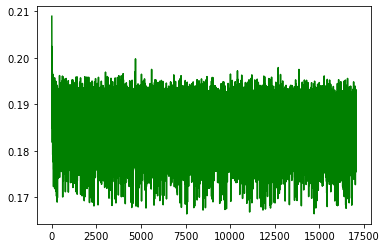

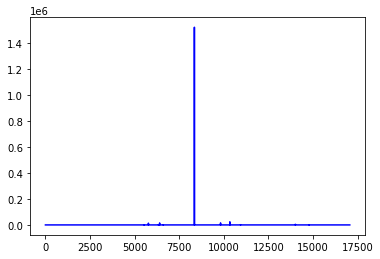

In [20]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(XX,batch)
    #print(range(batch))
    for i in range(batch):
        #localX = torch.tensor(b[i].cuda())
        localX = torch.tensor(b[i])
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""
        optimizer.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer2.step()
        scheduler.step()
        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = torch.mean(localX/recon)

        if idx%30 == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))
p1 = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')
p2 = plt.figure()
plt.plot(anomaly_history,'b-',label='h 10,z 2')